# Brain tumor segmentation from MRI

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Dataset/image_segmentation_Pet_Dataset/archive.zip" -d "/content/Dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: /content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: /content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: /content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: /content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: /content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: /content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: /content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: /conte

# Data Preprocessing

In [21]:
import os
import random
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG19

from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display
from keras.models import load_model
from keras.losses import binary_crossentropy

In [2]:
data_map = []

# Iterate over subdirectories in the specified path
for sub_dir_path in glob.glob("/content/Dataset/lgg-mri-segmentation/kaggle_3m/"+"*"):
    # Check if the current path is a directory
    if os.path.isdir(sub_dir_path):
        try:
            dir_name = sub_dir_path.split('/')[-1]

            # Iterate over files in the directory
            for filename in os.listdir(sub_dir_path):
                image_path = os.path.join(sub_dir_path, filename)
                data_map.extend([dir_name, image_path])
        except Exception as e:
            print(e)

# Display the data_map
print(data_map)


['TCGA_CS_4942_19970222', '/content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_13_mask.tif', 'TCGA_CS_4942_19970222', '/content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_6_mask.tif', 'TCGA_CS_4942_19970222', '/content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_19.tif', 'TCGA_CS_4942_19970222', '/content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_16.tif', 'TCGA_CS_4942_19970222', '/content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_18.tif', 'TCGA_CS_4942_19970222', '/content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_9_mask.tif', 'TCGA_CS_4942_19970222', '/content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_5.tif', 'TCGA_CS_4942_19970222', '/content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19970222/TC

The code is creating a DataFrame, a table-like structure in pandas.

It has two columns: "patient_id" and "path."

"patient_id" stores patient IDs, and "path" stores corresponding image paths.

The DataFrame is displayed to show a preview of the data.

In [3]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

patient_id                                               path
0  TCGA_CS_4942_19970222  /content/Dataset/lgg-mri-segmentation/kaggle_3...
1  TCGA_CS_4942_19970222  /content/Dataset/lgg-mri-segmentation/kaggle_3...
2  TCGA_CS_4942_19970222  /content/Dataset/lgg-mri-segmentation/kaggle_3...
3  TCGA_CS_4942_19970222  /content/Dataset/lgg-mri-segmentation/kaggle_3...
4  TCGA_CS_4942_19970222  /content/Dataset/lgg-mri-segmentation/kaggle_3...

In [4]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN = 89
END_IMG_LEN = 4
END_MASK_LEN = 9

imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_19.tif 
Path to the Mask: /content/Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_19_mask.tif


In [5]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 :
        return 1
    else:
        return 0

brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

patient_id  \
0     TCGA_CS_4942_19970222   
1     TCGA_CS_4942_19970222   
2     TCGA_CS_4942_19970222   
3     TCGA_CS_4942_19970222   
4     TCGA_CS_4942_19970222   
...                     ...   
3924  TCGA_DU_7298_19910324   
3925  TCGA_DU_7298_19910324   
3926  TCGA_DU_7298_19910324   
3927  TCGA_DU_7298_19910324   
3928  TCGA_DU_7298_19910324   

                                             image_path  \
0     /content/Dataset/lgg-mri-segmentation/kaggle_3...   
1     /content/Dataset/lgg-mri-segmentation/kaggle_3...   
2     /content/Dataset/lgg-mri-segmentation/kaggle_3...   
3     /content/Dataset/lgg-mri-segmentation/kaggle_3...   
4     /content/Dataset/lgg-mri-segmentation/kaggle_3...   
...                                                 ...   
3924  /content/Dataset/lgg-mri-segmentation/kaggle_3...   
3925  /content/Dataset/lgg-mri-segmentation/kaggle_3...   
3926  /content/Dataset/lgg-mri-segmentation/kaggle_3...   
3927  /content/Dataset/lgg-mri-segmentation/kaggle_3...   
3928  /content/Dataset/lgg-mri-segmentation/kaggle_3...   

                                              mask_path  mask  
0     /content/Dataset/lgg-mri-segmentation/kaggle_3...     0  
1     /content/Dataset/lgg-mri-segmentation/kaggle_3...     0  
2     /content/Dataset/lgg-mri-segmentation/kaggle_3...     0  
3     /content/Dataset/lgg-mri-segmentation/kaggle_3...     0  
4     /content/Dataset/lgg-mri-segmentation/kaggle_3...     0  
...                                                 ...   ...  
3924  /content/Dataset/lgg-mri-segmentation/kaggle_3...     0  
3925  /content/Dataset/lgg-mri-segmentation/kaggle_3...     0  
3926  /content/Dataset/lgg-mri-segmentation/kaggle_3...     0  
3927  /content/Dataset/lgg-mri-segmentation/kaggle_3...     0  
3928  /content/Dataset/lgg-mri-segmentation/kaggle_3...     0  

[3929 rows x 4 columns]

In [6]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

# Visulaizing Dataset


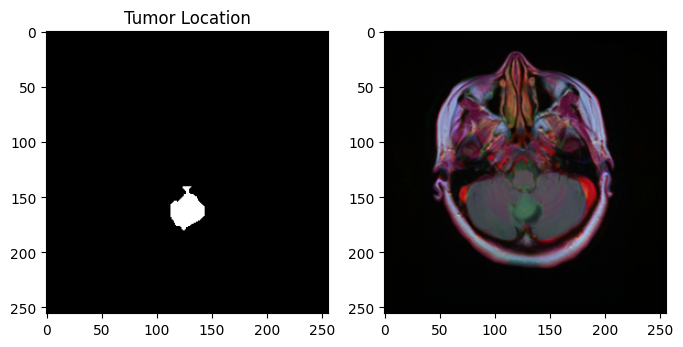

In [7]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

In [8]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

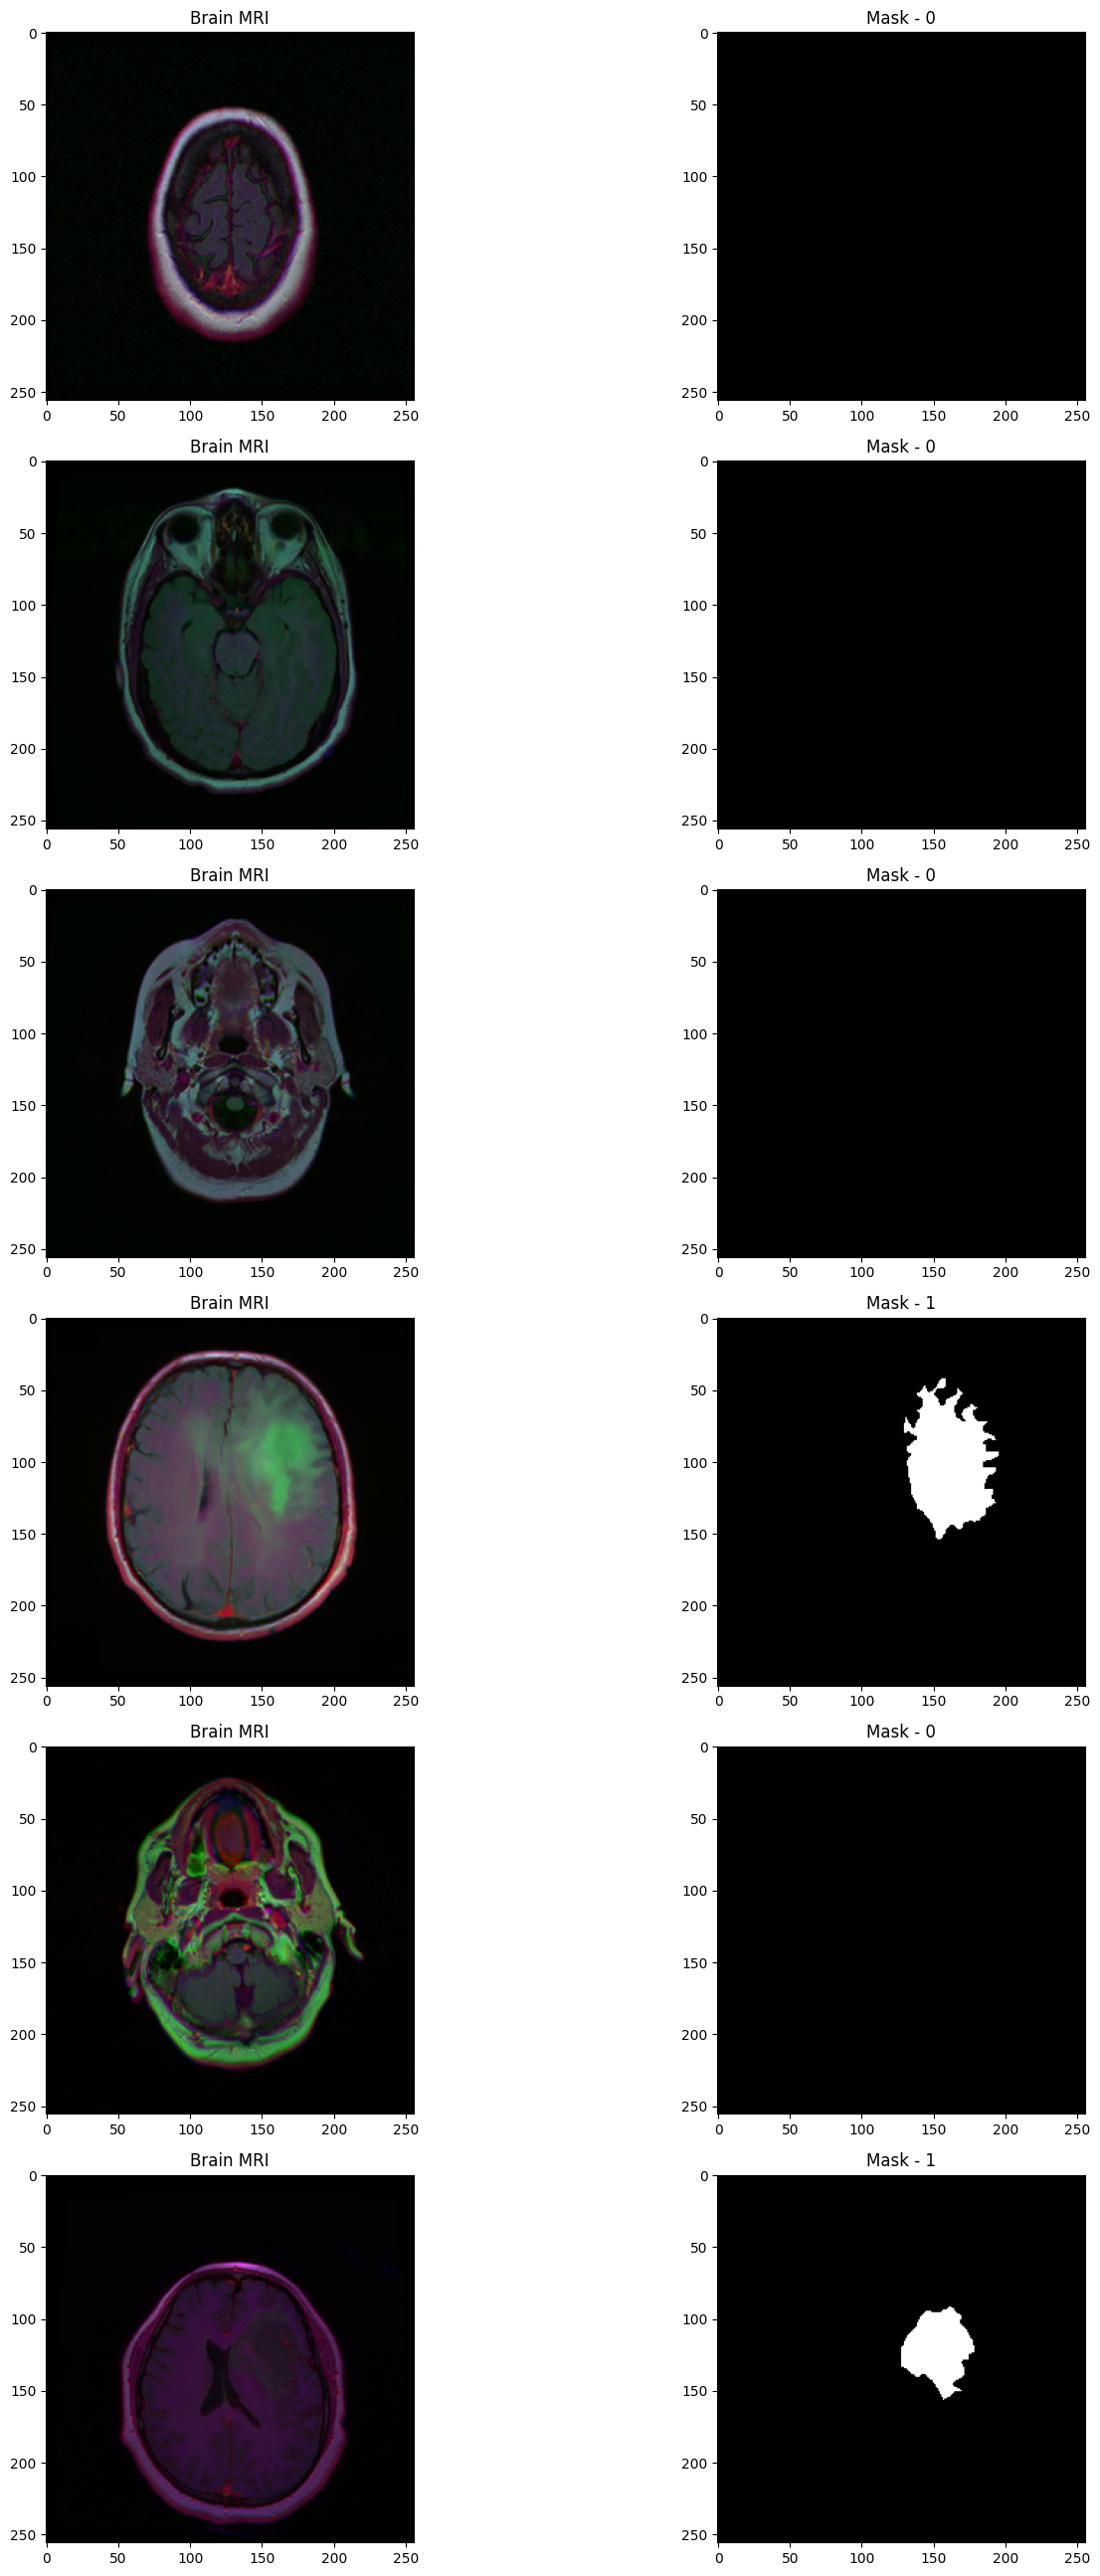

In [9]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately

fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

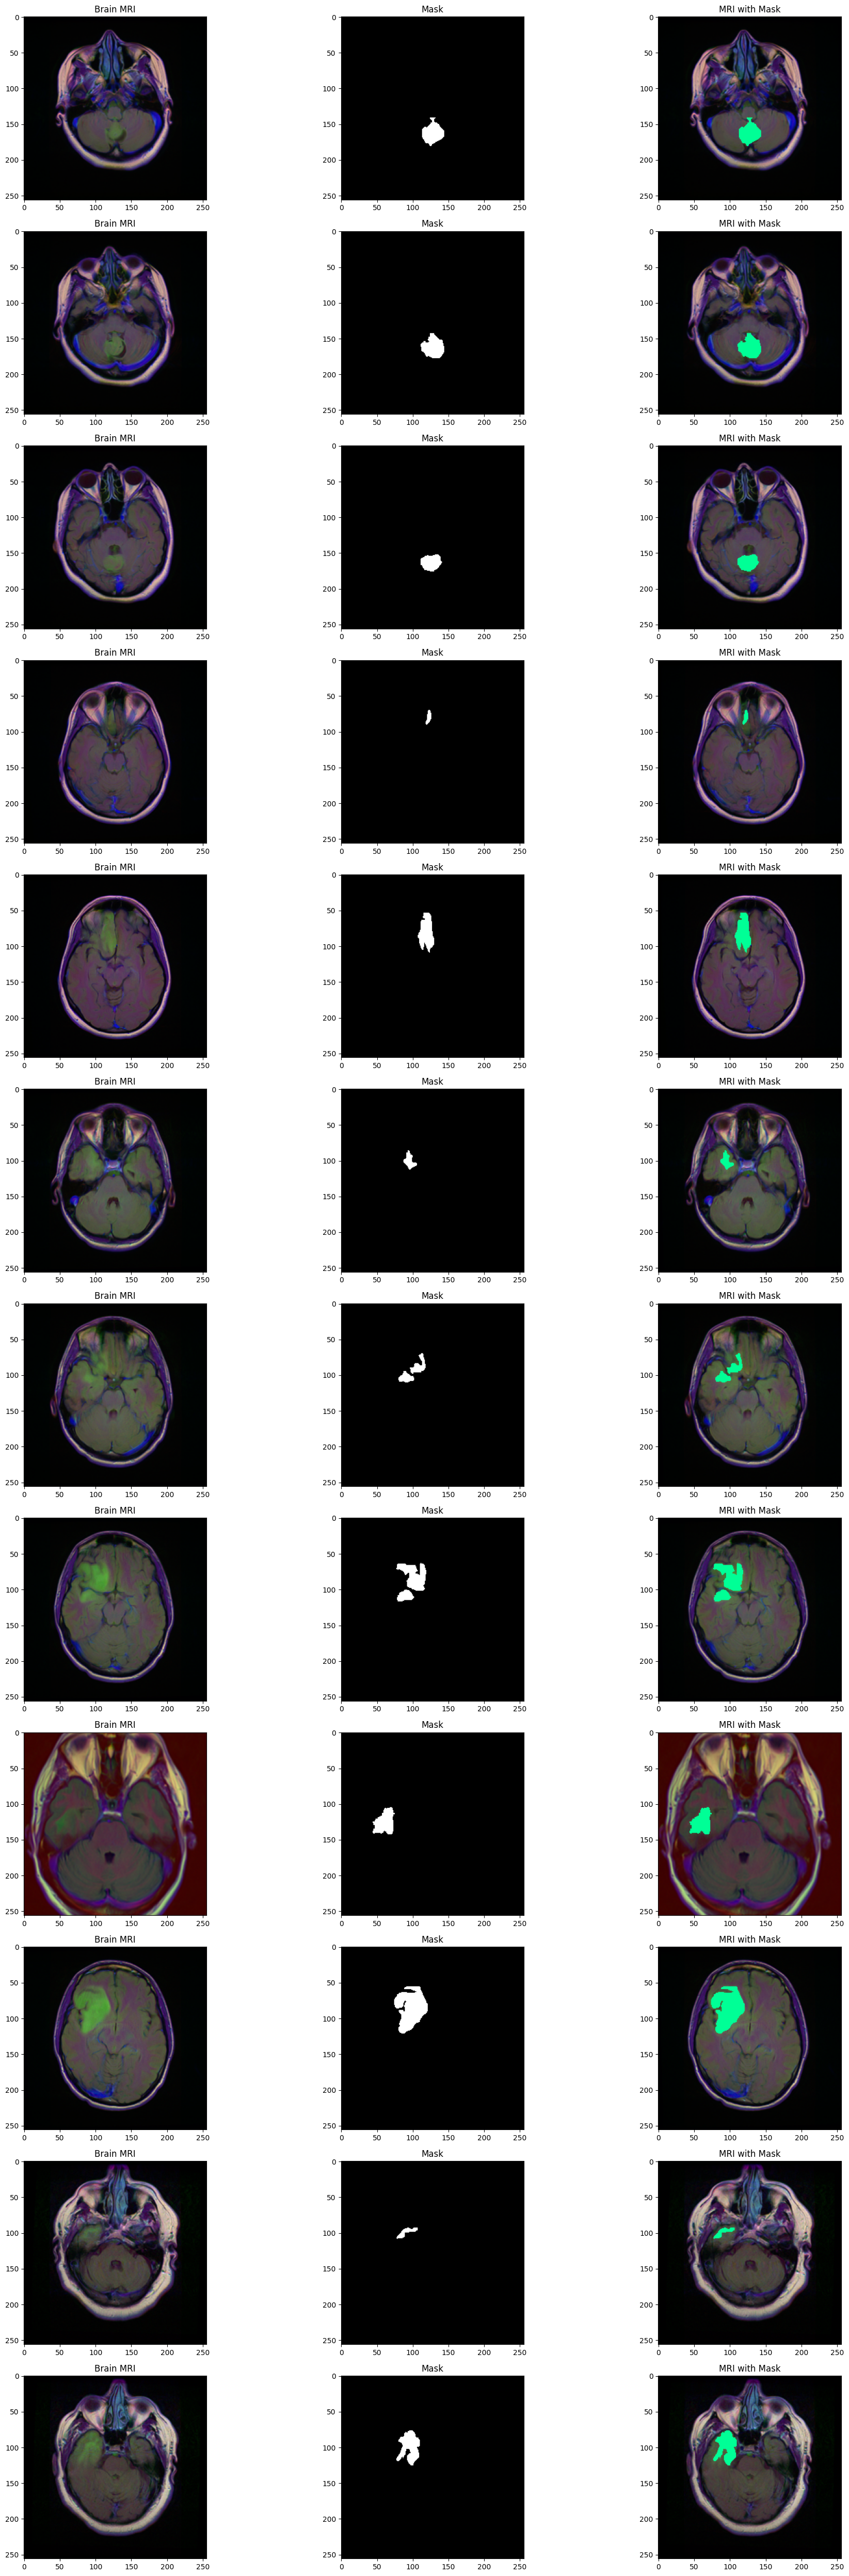

In [10]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')

        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break

fig.tight_layout()

In [11]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [12]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

# Training and Testing

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)

In [14]:
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [15]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'

    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth)
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])

      #mask path
      mask_path = str(list_mask[i])

      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)

      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising
      img -= img.mean()
      img /= img.std()

      mask -= mask.mean()
      mask /= mask.std()

      #Adding image to the empty array
      X[i,] = img

      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)

    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

In [16]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output
    s2 = vgg19.get_layer("block2_conv2").output
    s3 = vgg19.get_layer("block3_conv4").output
    s4 = vgg19.get_layer("block4_conv4").output

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model
seg_model = build_vgg19_unet((256,256,3))
seg_model.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                        

# Defining custom Loss function

In [17]:

from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [18]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam,
                  loss = focal_tversky,
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

I have trained the model till epoch 157 and found it good enough for my purposes.

In [ ]:
h = seg_model.fit(train_data,
                  epochs = 200,
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

## 8) Visualizing the metrics of model of our model

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

2/6 [=========>....................] - ETA: 2:50 - loss: 0.9909 - tversky: 0.0122

# Load Model

In [22]:
model_path = '/content/drive/MyDrive/Dataset/image_segmentation_Pet_Dataset/ResUNet-segModel-weights.hdf5'
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

loaded_model = load_model(model_path, custom_objects={
    'tversky': tversky,
    'focal_tversky': focal_tversky,
    'tversky_loss': tversky_loss
})


In [28]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

def visualize_segmentation_results(model, X_test):
    # Loop through each row in X_test
    for index, row in X_test.head(6).iterrows():
        # Load the image
        img_path = row['image_path']
        img = io.imread(img_path)
        img = cv2.resize(img, (256, 256))
        img = np.array(img, dtype=np.float64)
        img -= img.mean()
        img /= img.std()

        # Load the original mask
        orig_mask_path = row['mask_path']
        orig_mask = io.imread(orig_mask_path)
        orig_mask = cv2.resize(orig_mask, (256, 256))

        # Create X array for prediction
        X = np.empty((1, 256, 256, 3))
        X[0, ] = img

        # Make prediction of mask
        predict = model.predict(X)
        pred_mask = np.array(predict).squeeze().round()

        # Plotting the images
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 5, 1)
        plt.imshow(img)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(orig_mask, cmap='gray')
        plt.title('Original Mask')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(img)
        plt.imshow(orig_mask, alpha=0.5, cmap='jet')
        plt.title('Image with Original Mask')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(img)
        plt.imshow(pred_mask, alpha=0.5, cmap='jet')
        plt.title('Image with Predicted Mask')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


1/1 [==============================] - 3s 3s/step


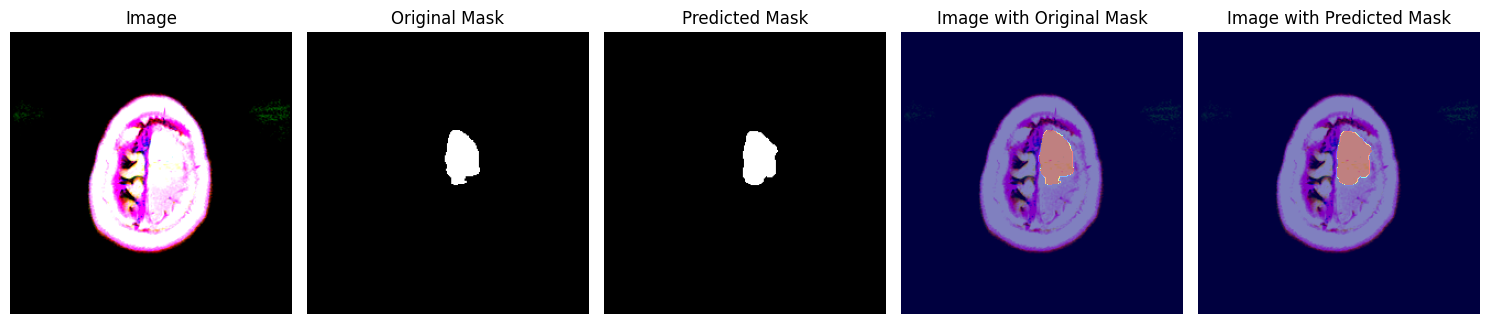

1/1 [==============================] - 2s 2s/step


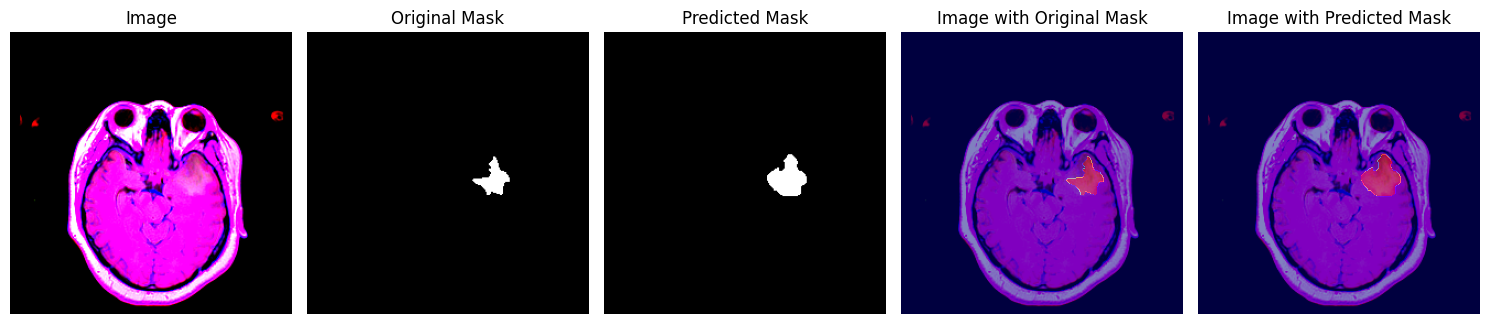

1/1 [==============================] - 2s 2s/step


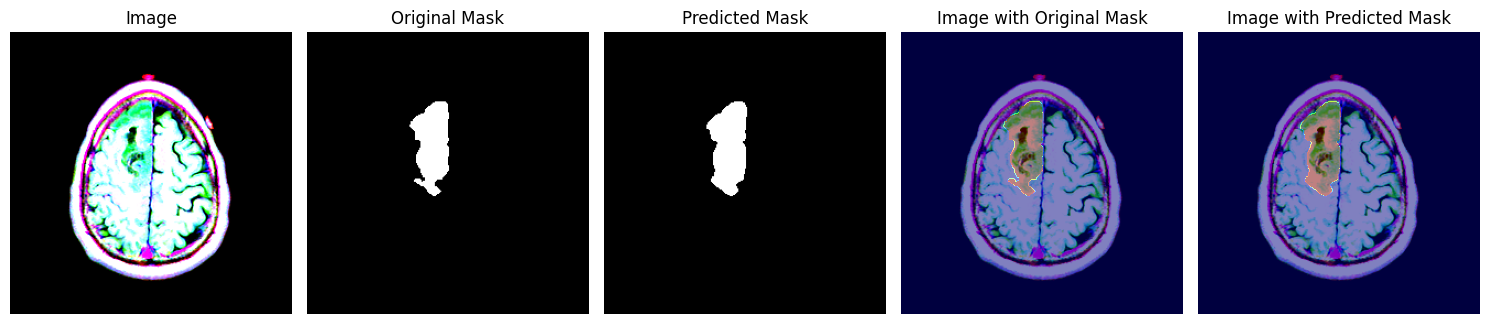

1/1 [==============================] - 2s 2s/step


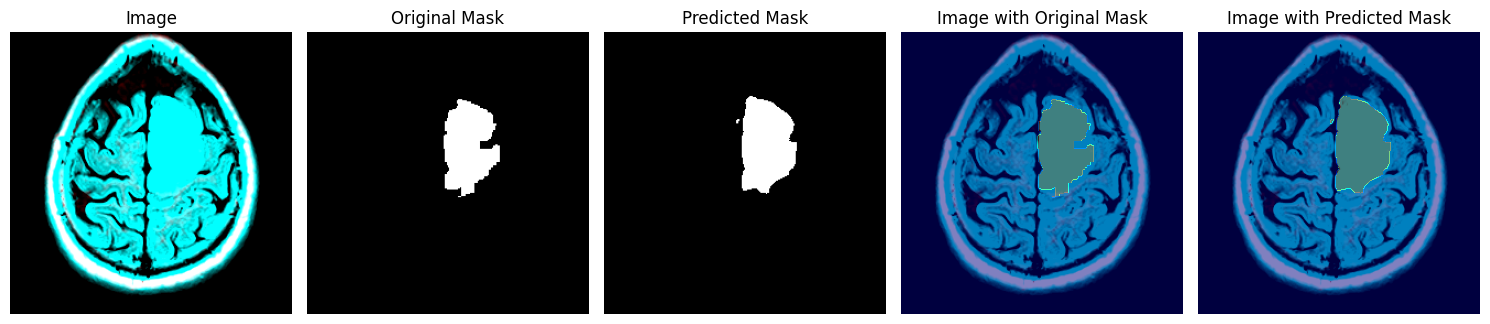

1/1 [==============================] - 2s 2s/step


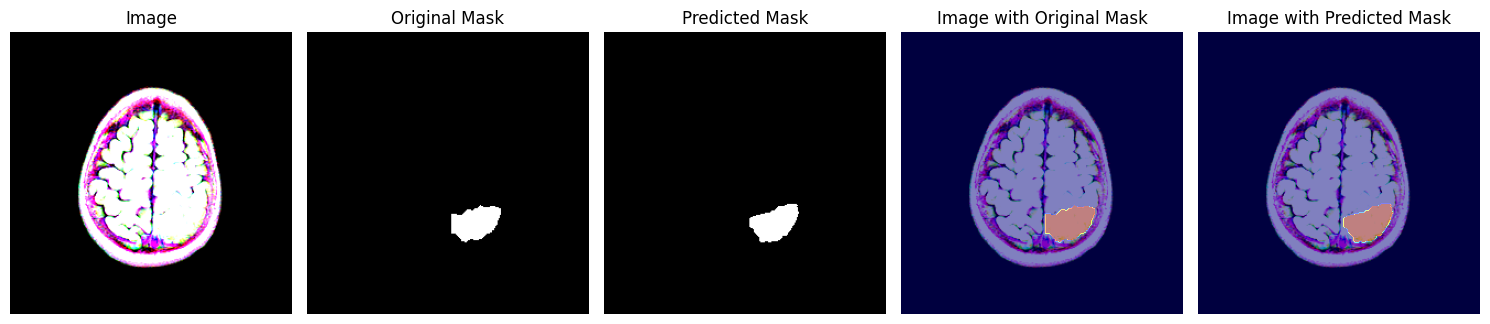

1/1 [==============================] - 3s 3s/step


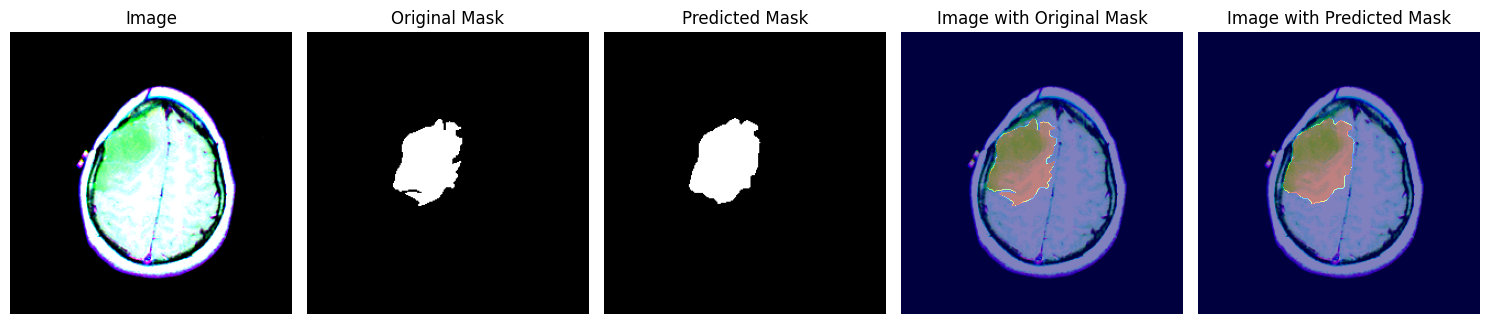

In [29]:
visualize_segmentation_results(loaded_model, X_test)